In [1]:
import pandas as pd
import numpy as np
import string as str
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

Tables importation and naming

In [2]:
sales = pd.read_csv("Aloe_Project_Sales.csv", sep=";")
clients = pd.read_csv("Aloe_Project_Clients.csv", sep=";")
salesreps = pd.read_csv("Aloe_Project_Sales_rep.csv", sep = ";")

Assigning the right types to the tables columns

In [3]:
#Sales
sales["code_cip_id"] = sales["code_cip_id"].astype("str")
sales["salesrep_id"] = sales["salesrep_id"].astype("str")
sales["quantity"] = sales["quantity"].astype("int")
sales["order_date"] = pd.to_datetime(sales["order_date"])

#Clients
clients["code_cip_id"] = clients["code_cip_id"].astype("str")
clients["postal_code"] = clients["postal_code"].astype("str")

#Sales_reps
salesreps["salesrep_id"] = salesreps["salesrep_id"].astype("str")

Data cleaning

In [4]:
#Removing special characters from the products' names and replacing them with the right ones
sales["article_name"] = sales["article_name"].apply(lambda x : x.replace("Ã©", "é").replace("Ãª", "ê").replace("Ã¨", "è"))

Some product's names contain what is called an EAN number at the end, it needs to be removed
All EAN numbers start with "- 8.02"

In [5]:
#Using a loop to go through the column, find the EAN number, split the string in two and keep the first part

new_values = []
for i, v in sales["article_name"].items():
    if "- 8.02" in v:
            v = v.replace("- 8.02", "removeafterthat")
            sep = "removeafterthat"
            v = v.split(sep, 1)[0]
            new_values.append(v)
    elif "- 8.02" not in v:
            v = v
            new_values.append(v)

sales["article_name"] = new_values

In [6]:
#Check
sales["article_name"].unique()

array(['Vide', 'Nutri-Pulpe 1000ml ', 'Nutri-Pulpe 500ml ',
       'Nutri-Pulpe Pêche Blanche 1000ml ',
       'Nutri-Pulpe Pêche Blanche 500ml ', 'Pur Gel Feuille 250ml ',
       'Pur Gel Flacon 100ml ', 'Aloe-Oil Huile Réparatrice 50ml ',
       "Cœur d'Aloe Cube", 'Totem Double Face',
       'Pop-Up Coeur D’Aloe Cube Offre Consommateur',
       'Présentoir de Sol Gamme Aloe',
       'Grand Aloe Vera Cartonné de Linéaire ou Vitrine',
       'Brochure Gamme Aloe Vera', 'Echantillon Nutri-Pulpe',
       'Echantillon Pur Gel',
       'Echantillon Nutri-Pulpe Goût Pêche Blanche',
       'Aloe-Oil Crème Réparatrice 150ml ',
       'Présentoir de Comptoir Aloe-Oil',
       'Réglette De Linéaire Aloe Vera',
       'Présentoir de Comptoir Gamme Aloe', "Cœur d'aloe cube",
       'Réglette de linéaire Aloe Vera', 'Totem double face',
       'Grand aloe vera cartonné de linéaire ou vitrine',
       'Pur Gel Feuille - 250ml ', 'Pur Gel Flacon - 100ml ',
       'Aloe-Oil Huile Réparatrice - 50ml 

In [7]:
#Removing spaces from the products' names
sales["article_name"] = sales["article_name"].apply(lambda x: x.strip())
#Adding caps at the begining of each word (some products are named the same but not recognised as the same because of caps changes)
sales["article_name"] = sales["article_name"].apply(lambda x: str.capwords(x, " "))

In [8]:
# Removing hyhens from products names, for example "Pur Gel Feuille - 250ml" = "Pur Gel Feuille 250ml"
without_hyphen = []
for i, v in sales["article_name"].items():
    if " - " in v:
        v = v.replace(" - ", " ")
        without_hyphen.append(v)
    elif " - " not in v:
        v = v
        without_hyphen.append(v)
    
sales["article_name"] = without_hyphen

The original excel file contains summary rows that are actually the sum of the rows below
(calculating the total revenue, and total product quantity of an order for example).They need to be removed.
The article name is always "Vide" for these rows.

There are a lot of nans in "unit_price", they are linked to sample or brochure giving.

There are also rows with 0 as a "unit price", they are linked to orders with 100% discount (mainly the same situation than brochure giving)

In [9]:
#Finding and deleting the "sum rows" + finding and deleting the "Ug" rows (containing free units)
empty_names_indexes = []
Ug_indexes = []

for i,v in sales["article_name"].items():
    if "Vide" in v:
        empty_names_indexes.append(i)
    if "Ug" in v:
        Ug_indexes.append(i)
        
sales = sales.drop(empty_names_indexes)
sales = sales.drop(Ug_indexes)

In [10]:
#Finding and deleting the "NANs" in unit_price
sales = sales.dropna(subset = ["unit_price"])

In [11]:
#Finding and deleting the "0" in unit_price
zeros_in_price_indexes = [i for i,v in sales["unit_price"].items() if v == 0]
sales = sales.drop(zeros_in_price_indexes)

In [12]:
sales["unit_price"]

1        24.9
2        16.9
3        24.9
4        16.9
5        16.9
         ... 
18615    12.5
18616    16.1
18618    16.9
18619     9.9
18620    16.9
Name: unit_price, Length: 6925, dtype: float64

In [13]:
sales.describe()

,primary_key,quantity,unit_price,net_revenue,Unnamed: 11
count,6925.000000,6925.000000,6925.000000,6925.000000,0.0
mean,11518.480289,11.568087,15.531509,97.087374,NaN
std,6609.612447,10.097096,4.743798,86.671938,NaN
min,89.000000,1.000000,8.900000,0.000000,NaN
25%,5579.000000,6.000000,9.900000,59.890000,NaN
50%,10934.000000,12.000000,16.900000,73.660000,NaN
75%,17425.000000,12.000000,16.900000,118.300000,NaN
max,22144.000000,150.000000,27.900000,1807.740000,NaN


CREATING A CLEAN SALES EXCEL FILE TO ANALYSE IN TABLEAU

In [14]:
sales.to_excel("cleaned_sales.xlsx", sheet_name='sales')

In this part, I will take a quick look at the main KPIs before importing the data in tableau

Merging the clients and sales tables. Common key : code_cip_id

In [15]:
clients_sales = sales.merge(clients)
clients_sales

,primary_key,order_reference,code_cip_id,salesrep_id,article_code,article_name,quantity,unit_price,discount,net_revenue,order_date,Unnamed: 11,uga,pharmacies_name,appellation_titulaire,owner_last_name,owner_first_name,commune,postal_code
0,19561,2105202234S0001,2260084,26,5046,Nutri-pulpe 1000ml,12,24.9,38%,185.26,2020-05-22,NaN,83SMA,PHARMACY NUM17193,Mme,Terence,Guilaine,COGOLIN,83310
1,19562,2105202234S0001,2260084,26,5047,Nutri-pulpe 500ml,12,16.9,38%,125.74,2020-05-22,NaN,83SMA,PHARMACY NUM17193,Mme,Terence,Guilaine,COGOLIN,83310
2,19563,2105202234S0001,2260084,26,5048,Nutri-pulpe Pêche Blanche 1000ml,6,24.9,38%,92.63,2020-05-22,NaN,83SMA,PHARMACY NUM17193,Mme,Terence,Guilaine,COGOLIN,83310
3,19564,2105202234S0001,2260084,26,5049,Nutri-pulpe Pêche Blanche 500ml,6,16.9,38%,62.87,2020-05-22,NaN,83SMA,PHARMACY NUM17193,Mme,Terence,Guilaine,COGOLIN,83310
4,19565,2105202234S0001,2260084,26,5050,Pur Gel Feuille 250ml,36,16.9,38%,377.21,2020-05-22,NaN,83SMA,PHARMACY NUM17193,Mme,Terence,Guilaine,COGOLIN,83310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6841,10459,2605220959S0003,2051212,29,5046,Nutri-pulpe 1000ml,6,24.9,38%,92.63,2022-05-27,NaN,95PON,PHARMACY NUM19934,M,Quincy,Camille,CERGY,95000
6842,10460,2605220959S0003,2051212,29,5047,Nutri-pulpe 500ml,6,16.9,38%,62.87,2022-05-27,NaN,95PON,PHARMACY NUM19934,M,Quincy,Camille,CERGY,95000
6843,10461,2605220959S0003,2051212,29,5048,Nutri-pulpe Pêche Blanche 1000ml,6,24.9,38%,92.63,2022-05-27,NaN,95PON,PHARMACY NUM19934,M,Quincy,Camille,CERGY,95000
6844,10462,2605220959S0003,2051212,29,5049,Nutri-pulpe Pêche Blanche 500ml,6,16.9,38%,62.87,2022-05-27,NaN,95PON,PHARMACY NUM19934,M,Quincy,Camille,CERGY,95000


Merging the sales rep and sales tables

In [16]:
#Left join because some sales reps have not sold any products yet, need to identify them
salesreps_sales = salesreps.merge(sales, how = "left")

In [17]:
salesreps_sales

,salesrep_id,last_name,first_name,primary_key,order_reference,code_cip_id,article_code,article_name,quantity,unit_price,discount,net_revenue,order_date,Unnamed: 11
0,1,Martin,Marie,16110.0,1707211740S0001,2249689,5050,Pur Gel Feuille 250ml,24.0,16.9,55%,182.52,2021-07-19,NaN
1,1,Martin,Marie,16111.0,1707211740S0001,2249689,5051,Pur Gel Flacon 100ml,24.0,9.9,55%,106.92,2021-07-19,NaN
2,1,Martin,Marie,16115.0,1707211651S0001,2003434,5051,Pur Gel Flacon 100ml,12.0,9.9,45%,65.34,2021-07-19,NaN
3,1,Martin,Marie,16121.0,1707211651S0001,2003434,5597,Pure Crème 400ml,12.0,14.9,45%,98.34,2021-07-19,NaN
4,1,Martin,Marie,16122.0,1707211651S0001,2003434,5598,Gyn-aloe Soin Lavant Pompe 400ml,6.0,16.1,45%,53.13,2021-07-19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6944,54,Dumont,Salomé,2037.0,2305221503S0019,2265606,5050,Pur Gel Feuille 250ml,24.0,16.9,55%,182.52,2022-05-24,NaN
6945,54,Dumont,Salomé,2038.0,2305221503S0019,2265606,5051,Pur Gel Flacon 100ml,24.0,9.9,55%,106.92,2022-05-24,NaN
6946,54,Dumont,Salomé,8508.0,2305221503S0019,2265606,5050,Pur Gel Feuille 250ml,24.0,16.9,55%,182.52,2022-05-24,NaN
6947,54,Dumont,Salomé,8509.0,2305221503S0019,2265606,5051,Pur Gel Flacon 100ml,24.0,9.9,55%,106.92,2022-05-24,NaN



SALES ANALYSIS


UGA analysis

In [18]:
#Top 10 UGA _ everything since 2020
top_10_ugas = clients_sales.groupby("uga")["net_revenue"].sum().sort_values(ascending = False).head(10)
top_10_ugas.to_frame()

,net_revenue
uga,
83DRA,61715.96
06CAG,39381.64
33BD3,16986.24
83SMA,16516.13
06GRA,16404.42
93ROS,14609.28
83FRE,13670.81
13M05,12513.29
83TL2,11414.95


UGA graph analysis (categorical plot)

In [19]:
#Top 10 UGAs plotting

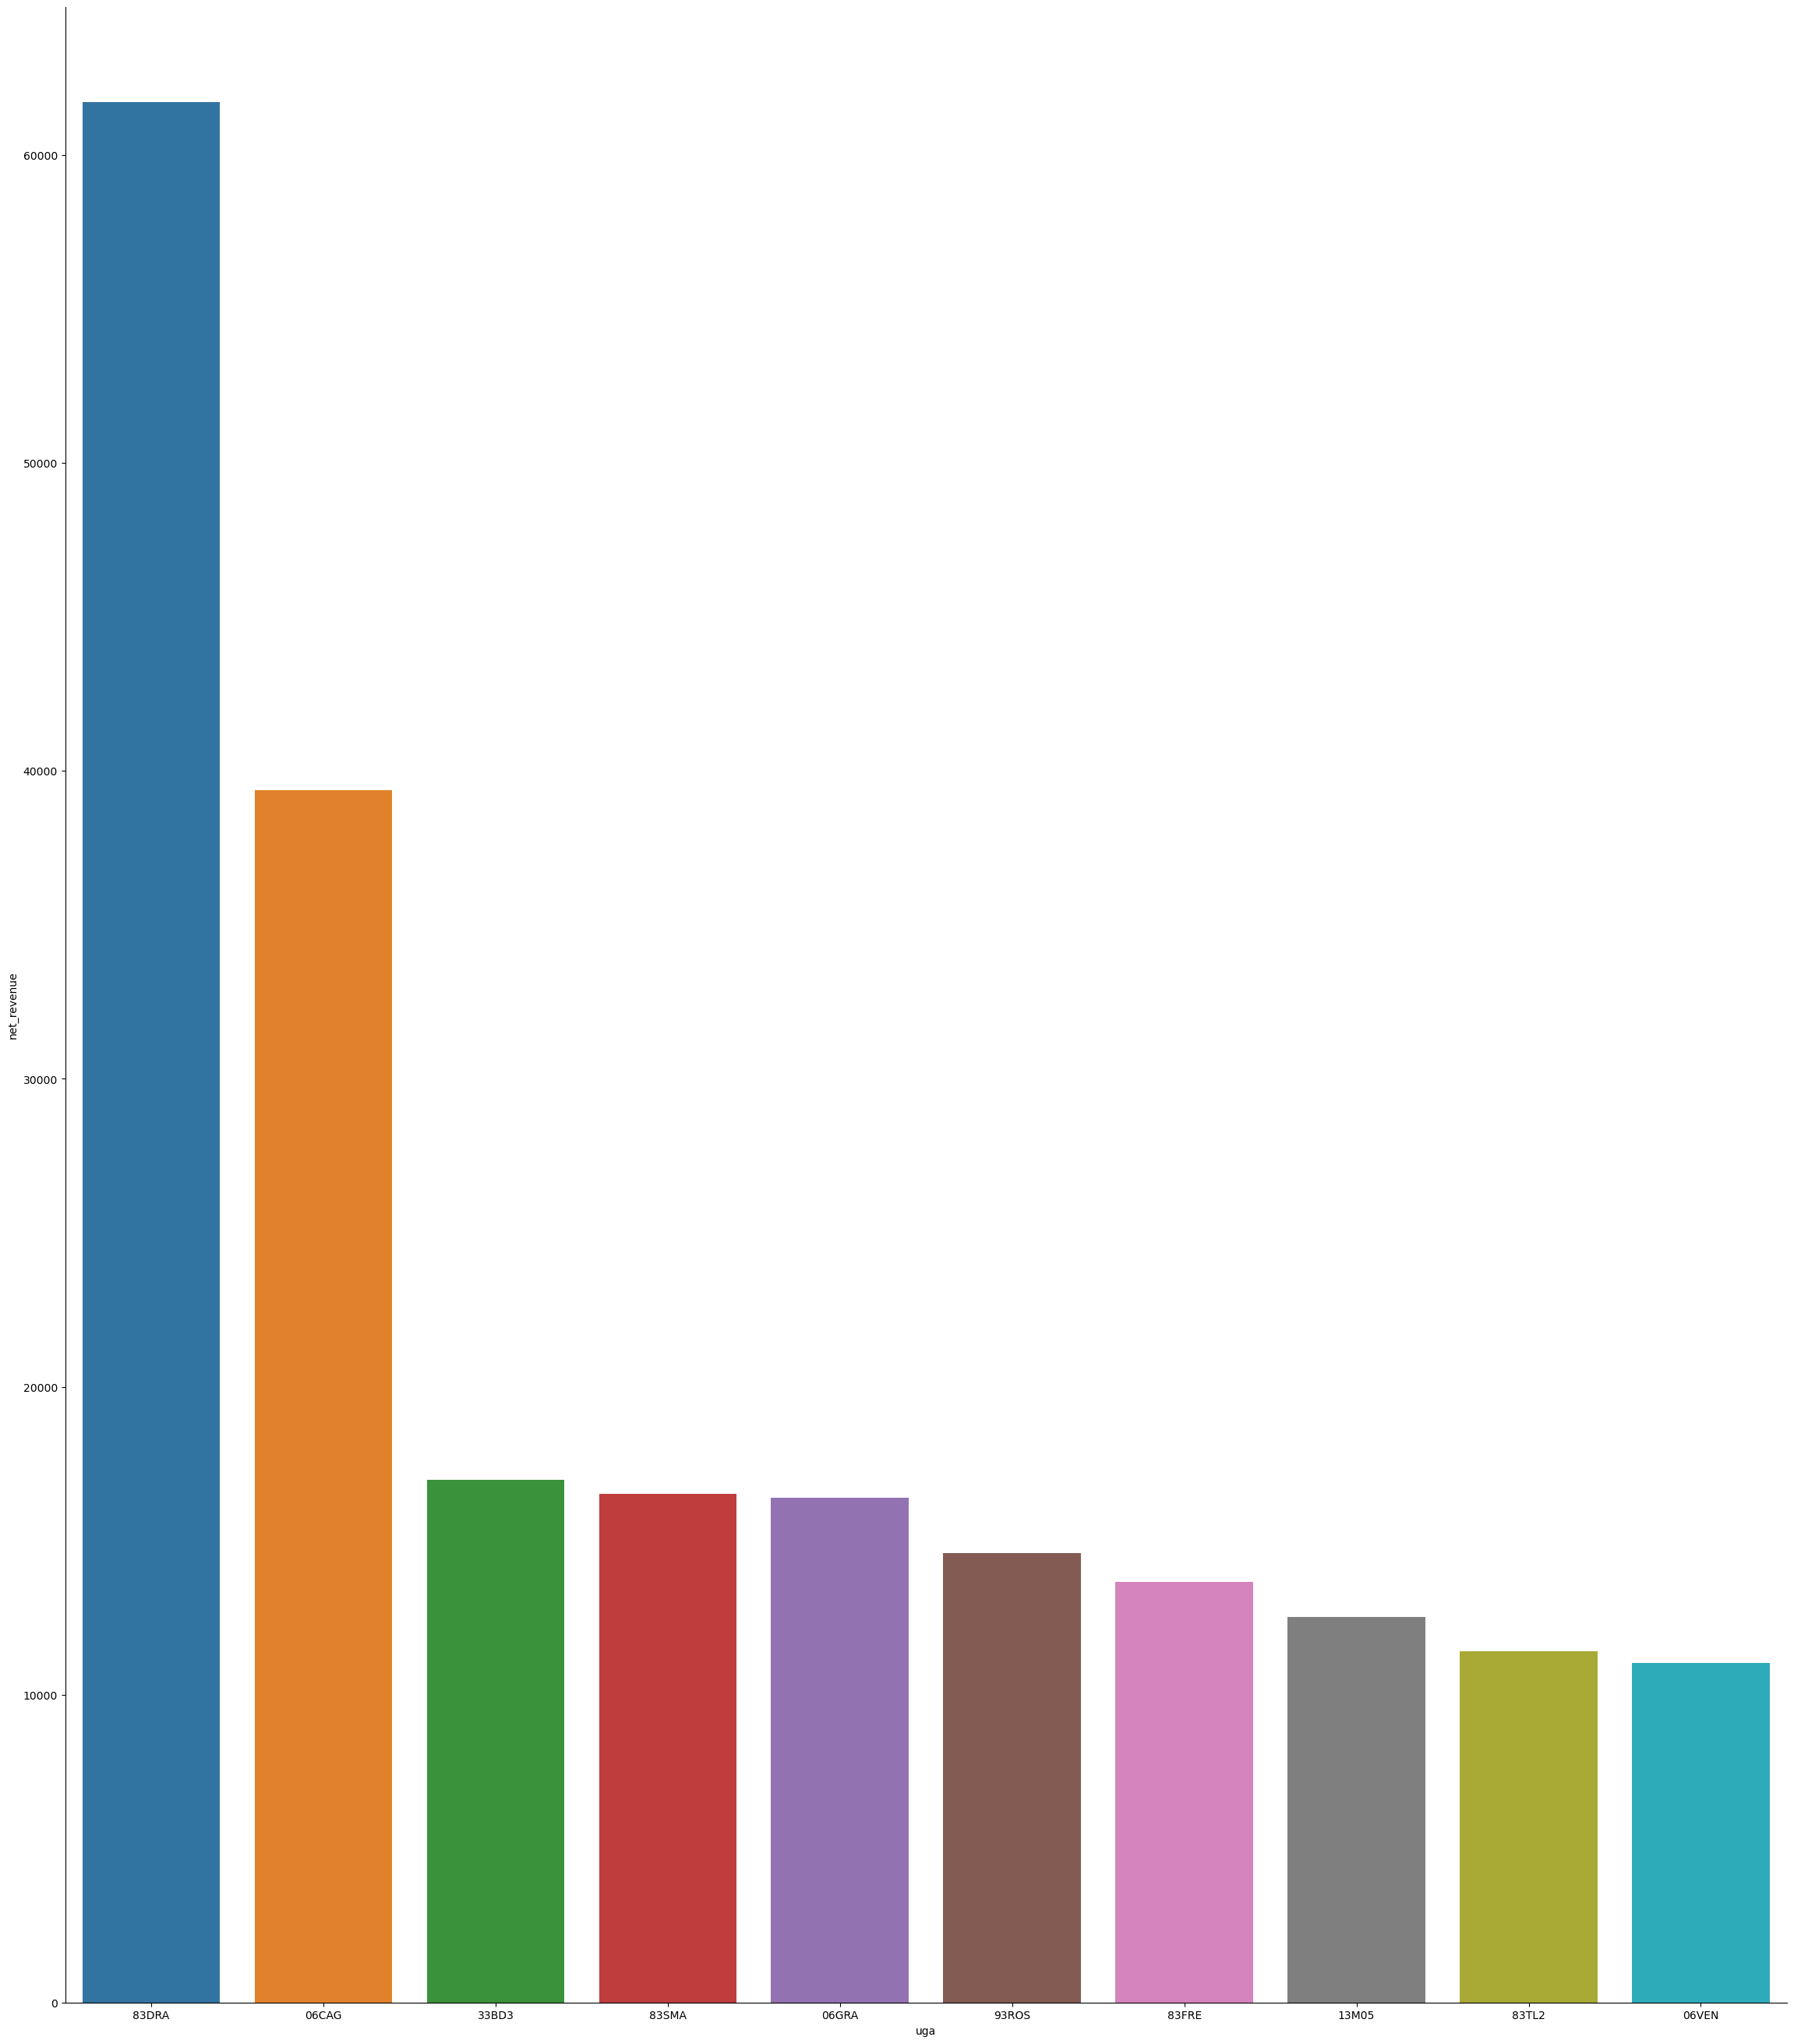

In [20]:
top_10_uga = top_10_ugas.reset_index()
sns.catplot(data=top_10_uga, x="uga", y = "net_revenue", kind = "bar")
plt.gcf().set_size_inches(28,30)
plt.show()

Large discrepancies between UGA's revenues

In [21]:
#Finding the top 25 products for each UGAs
#Top 25 products with related UGAs _ everything since 2020
clients_sales.groupby(["uga", "article_name"])["net_revenue"].sum().sort_values(ascending = False).to_frame().head(25)

net_revenue
uga   article_name                                 
83DRA Pur Gel Feuille 250ml                15907.69
06CAG Pur Gel Feuille 250ml                10434.09
83DRA Pur Gel Flacon 100ml                 10431.86
      Aloe-oil Crème Réparatrice 150ml      7993.22
33BD3 Nutri-pulpe 1000ml                    7230.96
83DRA Aloe-oil Huile Réparatrice 50ml       6564.10
      Nutri-pulpe 1000ml                    5765.38
06CAG Pur Gel Flacon 100ml                  5104.85
83SMA Pur Gel Feuille 250ml                 4966.58
33BD3 Nutri-pulpe 500ml                     4907.76
06CAG Nutri-pulpe 1000ml                    4673.24
13M05 Pur Gel Feuille 250ml                 4585.32
83FRE Pur Gel Feuille 250ml                 4305.45
06GRA Pur Gel Feuille 250ml                 3849.16
83SAN Pur Gel Feuille 250ml                 3814.68
06CAG Aloe-oil Crème Réparatrice 150ml      3704.10
83DRA Nutri-pulpe 500ml                     3646.37
06CAG Nutri-pulpe 500ml                     3610.87
83TL2 Pur Gel Feuille 250ml                 3526.73
59VAL Pur Gel Feuille 250ml                 3520.58
93ROS Pur Gel Feuille 250ml                 3513.54
06CAG Aloe-oil Huile Réparatrice 50ml       3336.30
92GEN Pur Gel Feuille 250ml                 3054.24
59ROU Pur Gel Feuille 250ml                 3017.70
83DRA Nutri-pulpe Pêche Blanche 1000ml      2929.75

In [22]:
#Tail 10 UGA _ everything since 2020
clients_sales.groupby("uga")["net_revenue"].sum().sort_values(ascending = False).tail(10).to_frame()

,net_revenue
uga,
85LSA,328.20
37LOC,324.77
75AUT,310.26
84CAR,292.03
84ORA,281.24
69BEL,281.24
29CON,251.48
42FEU,241.38
75CLI,205.13


Products

In [23]:
#Top 10 produtcs _ everything since 2020
sales.groupby("article_name")["net_revenue"].sum().sort_values(ascending = False).head(10).to_frame()

,net_revenue
article_name,
Pur Gel Feuille 250ml,184426.3700
Pur Gel Flacon 100ml,98695.2700
Aloe-oil Crème Réparatrice 150ml,64822.4400
Aloe-oil Huile Réparatrice 50ml,59785.2825
Nutri-pulpe 1000ml,53145.9600
Nutri-pulpe 500ml,52402.1700
Nutri-pulpe Pêche Blanche 500ml,47444.5100
Nutri-pulpe Pêche Blanche 1000ml,31723.4500
Pure Crème 400ml,27015.6600


All products sales over time

In [24]:
all_sales_over_time = clients_sales[["article_name","net_revenue","order_date"]]
all_sales_over_time = all_sales_over_time.groupby(["order_date"])["net_revenue"].sum()
all_sales_over_time = all_sales_over_time.reset_index()
all_sales_over_time

,order_date,net_revenue
0,2020-05-22,3401.26
1,2020-05-26,860.84
2,2020-05-27,546.85
3,2020-05-29,325.14
4,2020-06-02,383.92
...,...,...
406,2022-05-24,1413.97
407,2022-05-25,1422.89
408,2022-05-27,1090.39
409,2022-05-30,600.74


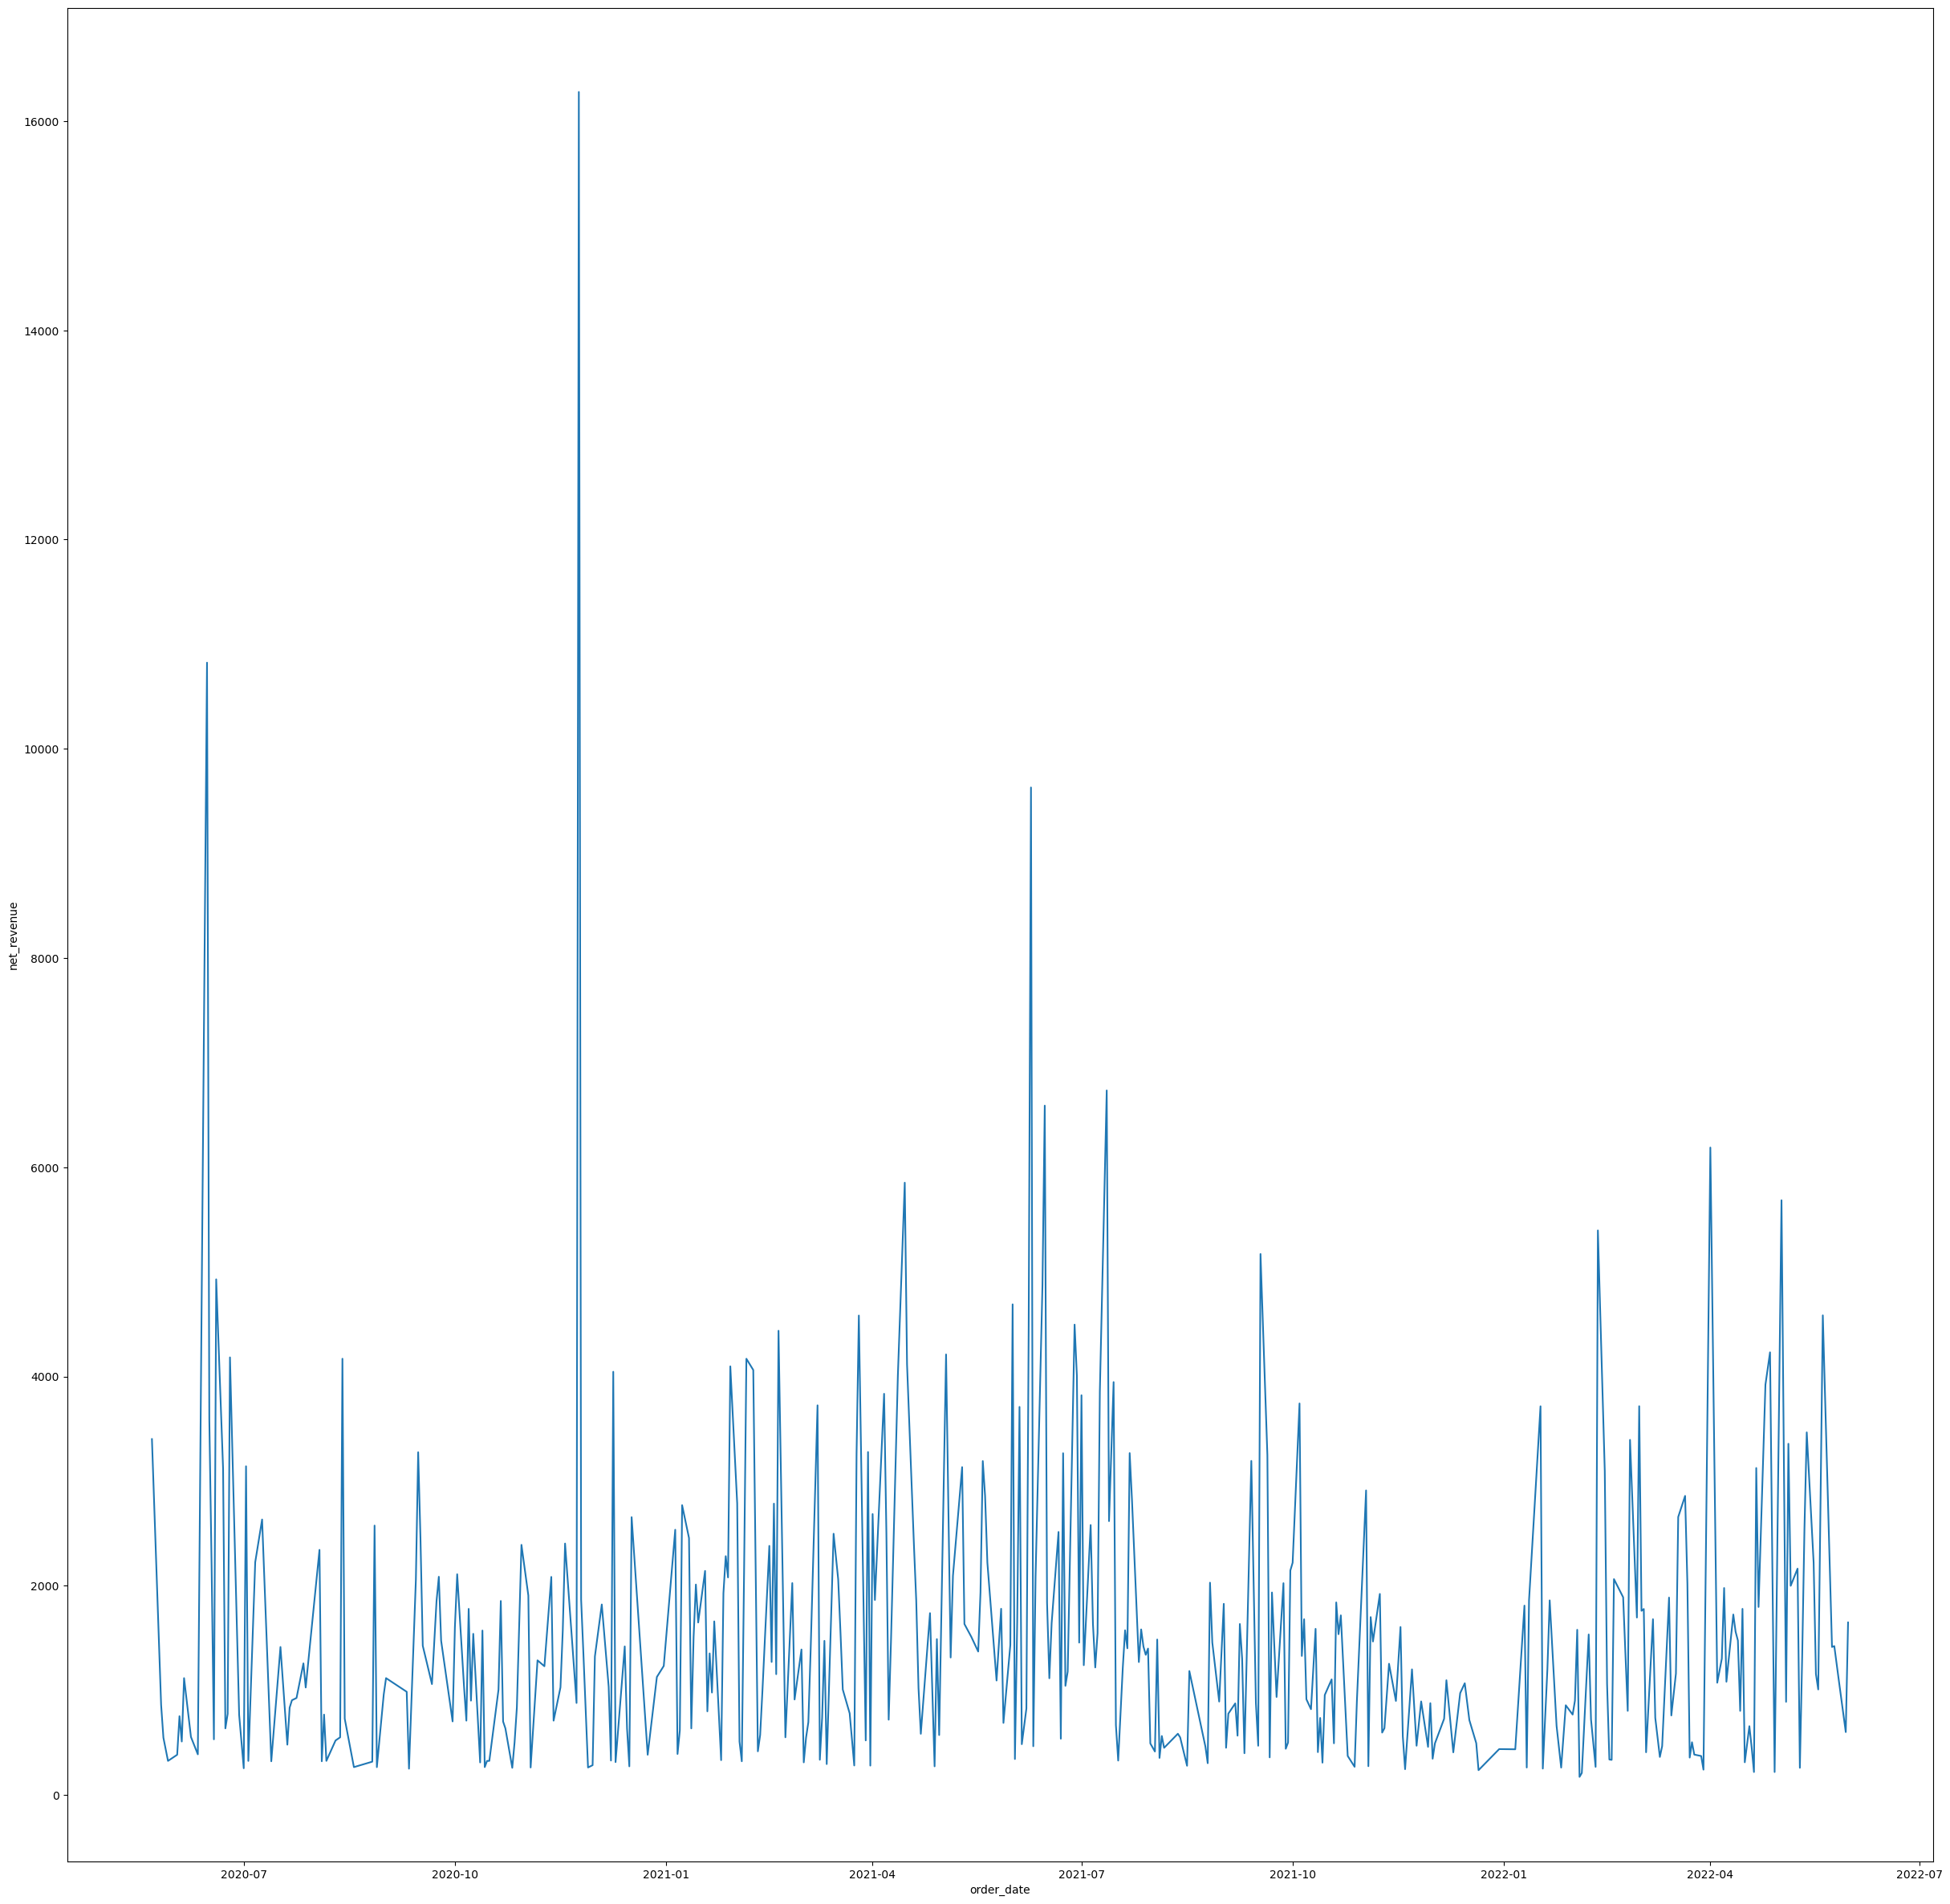

In [25]:
sns.lineplot(data = all_sales_over_time, x = "order_date", y = "net_revenue" )
plt.gcf().set_size_inches(30,30)
plt.show()

ALL product sales in 2020 and 2021 2022

2020

In [26]:
start = pd.to_datetime("2020-01-01")
end = pd.to_datetime("2020-12-01")
sales_2020_over_time = clients_sales[clients_sales["order_date"].between(start,end)]
sales_2020_over_time.sort_values(by = ["order_date"])

,primary_key,order_reference,code_cip_id,salesrep_id,article_code,article_name,quantity,unit_price,discount,net_revenue,order_date,Unnamed: 11,uga,pharmacies_name,appellation_titulaire,owner_last_name,owner_first_name,commune,postal_code
0,19561,2105202234S0001,2260084,26,5046,Nutri-pulpe 1000ml,12,24.9,38%,185.26,2020-05-22,NaN,83SMA,PHARMACY NUM17193,Mme,Terence,Guilaine,COGOLIN,83310
65,19634,2005201439S0001,2006719,26,5050,Pur Gel Feuille 250ml,12,16.9,38%,125.74,2020-05-22,NaN,83DRA,PHARMACY NUM17333,M,Mayssa,Gertrude,SALERNES,83690
66,19635,2005201439S0001,2006719,26,5052,Aloe-oil Huile Réparatrice 50ml,12,8.9,38%,66.22,2020-05-22,NaN,83DRA,PHARMACY NUM17333,M,Mayssa,Gertrude,SALERNES,83690
57,19602,2005201446S0001,2212245,26,5051,Pur Gel Flacon 100ml,12,9.9,38%,73.66,2020-05-22,NaN,83FRE,PHARMACY NUM17342,M,Matthéo,Gui,ST RAPHAEL,83700
56,19601,2005201446S0001,2212245,26,5050,Pur Gel Feuille 250ml,12,16.9,38%,125.74,2020-05-22,NaN,83FRE,PHARMACY NUM17342,M,Matthéo,Gui,ST RAPHAEL,83700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,19608,0112203144S0001,2213144,26,5050,Pur Gel Feuille 250ml,36,16.9,46%,328.54,2020-12-01,NaN,83TL2,PHARMACY NUM17033,M,Marine,Mabelle,TOULON,83000
379,19607,0112203144S0001,2213144,26,5049,Nutri-pulpe Pêche Blanche 500ml,12,16.9,46%,109.51,2020-12-01,NaN,83TL2,PHARMACY NUM17033,M,Marine,Mabelle,TOULON,83000
378,19606,0112203144S0001,2213144,26,5048,Nutri-pulpe Pêche Blanche 1000ml,6,24.9,46%,80.68,2020-12-01,NaN,83TL2,PHARMACY NUM17033,M,Marine,Mabelle,TOULON,83000
2609,1841,2711201623S0005,2180287,34,5049,Nutri-pulpe Pêche Blanche 500ml,3,16.9,30%,35.49,2020-12-01,NaN,70VES,PHARMACY NUM13801,Mme,Maryne,Blank,ST SAUVEUR,70300


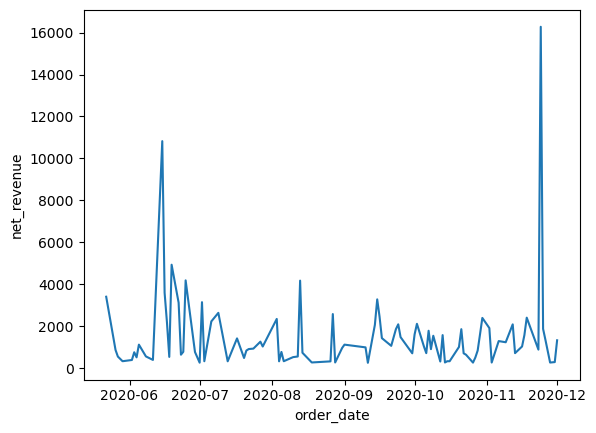

In [27]:
sales_2020_over_time = sales_2020_over_time[["article_name", "net_revenue", "order_date"]]
sales_2020_over_time = sales_2020_over_time.groupby("order_date")["net_revenue"].sum()
sales_2020_over_time =sales_2020_over_time.reset_index()
sns.lineplot(data = sales_2020_over_time, x = "order_date", y = "net_revenue" )
plt.show()
plt.gcf().set_size_inches(28,30)

Sales peek due to high sale of "Pur Gel Feuille 250ml" on the related days

In [28]:
#Tails 10 products _ everything since 2020
sales.groupby("article_name")["net_revenue"].sum().sort_values(ascending = False).tail(25).to_frame()

,net_revenue
article_name,
Pur Gel Feuille 250ml,184426.3700
Pur Gel Flacon 100ml,98695.2700
Aloe-oil Crème Réparatrice 150ml,64822.4400
Aloe-oil Huile Réparatrice 50ml,59785.2825
Nutri-pulpe 1000ml,53145.9600
Nutri-pulpe 500ml,52402.1700
Nutri-pulpe Pêche Blanche 500ml,47444.5100
Nutri-pulpe Pêche Blanche 1000ml,31723.4500
Pure Crème 400ml,27015.6600


Sales Rep

In [29]:
#Top 10 sales reps (sellers)_ everything since 2020
salesreps_sales.groupby("first_name")["net_revenue"].sum().sort_values(ascending = False).head(10).to_frame()

,net_revenue
first_name,
Louis,148182.61
Marie,119901.29
Olivia,52391.69
Pauline,49776.63
Bernard,42438.30
Jacques,35591.50
René,29187.53
Lara,28891.19
Marcel,25453.50


In [30]:
#last 12 sellers_everything since 2020
salesreps_sales.groupby("first_name")["net_revenue"].sum().sort_values(ascending = False).tail(12).to_frame()

,net_revenue
first_name,
Christiane,0.0
Marguerite,0.0
Christine,0.0
Madeleine,0.0
Louise,0.0
Claire,0.0
Denise,0.0
Françoise,0.0
Jeanne,0.0


Buyers

In [31]:
#Top 10 buyers_ everything since 2020
clients_sales[["code_cip_id", "pharmacies_name","net_revenue"]].groupby(["code_cip_id","pharmacies_name"])["net_revenue"].sum().sort_values(ascending = False).to_frame().head(10)

,,net_revenue
code_cip_id,pharmacies_name,
2102240,PHARMACY NUM5440,16986.24
2241522,PHARMACY NUM986,13073.40
2048765,PHARMACY NUM19194,13037.88
2007231,PHARMACY NUM1764,10593.30
2042674,PHARMACY NUM17261,9475.77
2235131,PHARMACY NUM19862,7107.75
2042412,PHARMACY NUM17325,6884.95
2012778,PHARMACY NUM1003,6788.37
2242919,PHARMACY NUM17204,6706.52
